# Analyse the output of the mini and ftc analysis

In [88]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

sys.path.append('../src/')
from plotting import get_coverage_threshold_and_size, get_auc

## Create a pipeline for calcualting the right metrics

In [73]:
base_path = Path('Ensembling_Finetuned_LLMs')

def read_file(file_path, base_path=base_path) -> pd.DataFrame:
    """
    Read a file and return a DataFrame.
    """
    path  = base_path / 'llm_experiments_data' / file_path
    if not path.exists():
        raise FileNotFoundError(f"File {path} does not exist.")
    return pd.read_csv(path)

#default to 99.9% coverage
def compute_metrics_rowise(row, base_path=base_path, target_coverage=0.999) -> pd.Series:
    npfile = base_path / row['path']
    data = np.load(npfile, allow_pickle=True)
    probs, labels = data['ensemble_probs'], data['labels']
    threshold, set_size = get_coverage_threshold_and_size(probs, labels, target_coverage=target_coverage)
    auc = get_auc(probs, labels)
    return pd.Series({
        'threshold': threshold,
        'set_size': set_size,
        'auc': auc
    })

def compute_metrics(df, base_path=base_path, target_coverage=0.999, output_path=None) -> None:
    """ compute metrics and save df """
    df = df.copy()
    tqdm.pandas(desc="Computing metrics")
    df[['threshold', 'set_size', 'auc']] = df.progress_apply(
        compute_metrics_rowise, axis=1, base_path=base_path, target_coverage=target_coverage
    )
    # Save the DataFrame to a CSV file
    df.to_csv(output_path, index=False)



### Run the pipline for mini and ftc

In [ ]:
mini_path_1 = 'llm_experimental_results_mini_neurips_2025-04-20.csv'
mini_path_2 = 'llm_experimental_results_mini_neurips_2025-04-24.csv'
ftc_path = 'llm_experimental_results_ftc_neurips_2025-04-25.csv'

df_mini_1 = read_file(mini_path_1)
df_mini_2 = read_file(mini_path_2)
df_ftc = read_file(ftc_path)

#compute metrics and save to csv
output_path_mini_1 = base_path / 'llm_experiments_data' / 'metrics' / 'mini_1_with_metrics.csv'
output_path_mini_2 = base_path / 'llm_experiments_data' / 'metrics' / 'mini_2_with_metrics.csv'
output_path_ftc = base_path / 'llm_experiments_data' / 'metrics' / 'ftc_with_metrics.csv'

compute_metrics(df_mini_1, base_path=base_path, target_coverage=0.999, output_path=output_path_mini_1)
compute_metrics(df_mini_2, base_path=base_path, target_coverage=0.999, output_path=output_path_mini_2)
compute_metrics(df_ftc, base_path=base_path, target_coverage=0.999, output_path=output_path_ftc)

## Load the new csv files and prepare the results for the report

In [101]:
def combine_and_clean_dataframes(df1, df2 = None) -> pd.DataFrame:
    """
    Combine and clean the dataframes.
    """
    parts = [df1]
    if df2 is not None:
        parts.append(df2)
    # Combine the dataframes
    combined_df = pd.concat(parts, ignore_index=True)
    combined_df = combined_df.drop_duplicates(subset=['dataset', 'seed', 'method', 'ensemble_type'], keep='first')
    combined_df.reset_index(drop=True, inplace=True)
    return combined_df

def calc_ci_for_df(df) -> pd.DataFrame:
    """
    Code assumes the right columns are present in the dataframe
    """
    #group by dataset, method, ensemble_type and calculate mean, std, count
    df = df.groupby(['dataset', 'method', 'ensemble_type'])[
    ['ensemble_size', 'ensemble_unique_size', 'nll_test', 'c1', 'c2', 'epi_scalar', 'threshold', 'set_size', 'auc' ]
    ].agg(
        ['mean', 'std', 'count']
        ).reset_index()
    # note we will get a double index
    columns = ['ensemble_size', 'ensemble_unique_size', 'nll_test', 'c1', 'c2', 'epi_scalar', 'threshold', 'set_size', 'auc' ]
    for col in columns:
        df[(col, 'CI')] = 1.96 * (df[(col, 'std')] / np.sqrt(df[(col, 'count')].replace(0, np.nan)))
        df[(col,'mean±CI')] = (df[(col, 'mean')].round(4).astype(str) + 
                              " ± " + df[(col, 'CI')].round(4).astype(str))
    return df

def flatten_subset_df(df, subset = ['dataset', 'method', 'ensemble_type', 'nll_test_mean±CI',
                                     'threshold_mean±CI', 'set_size_mean±CI', 'auc_mean±CI']) -> pd.DataFrame:
    """
    Flatten the dataframe
    """
    # Flatten the multi-index columns
    df.columns = [
                '_'.join(col).strip('_') if col[1] else col[0] 
                  for col in df.columns.values]
    #return subset of columns
    return df[subset]



### Functions for determining statistical significance

In [89]:
from scipy.stats import ttest_ind_from_stats, norm

def compare_to_best(
    df: pd.DataFrame,
    metric: str,
    ensemble_types: list = ['greedy_unique_5_baseline',
                            'greedy_unique_5_temp_baseline',
                            'greedy_unique_5_post_calib',
                            'greedy_50_baseline',
                            'greedy_50_temp_baseline',
                            'greedy_50_post_calib',
                            'greedy_50_calib_once',
                            'greedy_50_calib_every_step'],
    calibration_method: str = 'pure_logits',
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    For each dataset, find the best ensemble_type on `metric`,
    then compare *all* ensemble_types to that best one.

    Args:
      df                 : DataFrame with columns
                           ['dataset','ensemble_type','method',
                            f'{metric}_mean', f'{metric}_std', f'{metric}_count', …]
      ensemble_types     : list of ensemble_type values to compare
      calibration_method : the `method` value to filter on (e.g. 'pure_logits')
      metric             : one of ['nll_test','threshold','set_size','auc']
      alpha              : for 95% CI and p<alpha test

    Returns:
      DataFrame with one row per (dataset, ensemble_type) containing:
        • best_ensemble_type  
        • mean & CI for that row & for the best  
        • ci_no_overlap (bool)  
        • significant (bool, p<alpha)  
        • p_value, t_stat
    """
    z = norm.ppf(1 - alpha/2)  # ≈1.96 for alpha=0.05
    print(f"Using z={z:.2f} for alpha={alpha:.2f}")
    results = []

    for ds in df['dataset'].unique():
        # restrict to this dataset, this calibration method, and only those ensemble_types
        sub = df[
            (df['dataset'] == ds) &
            (df['method']  == calibration_method) &
            (df['ensemble_type'].isin(ensemble_types))
        ].copy()

        if sub.empty:
            print(f"Warning: No data for dataset {ds} with method {calibration_method} and ensemble types {ensemble_types}")
            break

        # compute 95% CI boundaries for every row
        sub[f'{metric}_ci_lo'] = sub[f'{metric}_mean'] - z * sub[f'{metric}_std'] / np.sqrt(sub[f'{metric}_count'])
        sub[f'{metric}_ci_hi'] = sub[f'{metric}_mean'] + z * sub[f'{metric}_std'] / np.sqrt(sub[f'{metric}_count'])

        # pick the best row
        if metric == 'auc':
            best_idx = sub[f'{metric}_mean'].idxmax()
        else:
            best_idx = sub[f'{metric}_mean'].idxmin()
        best = sub.loc[best_idx]
        print(f"{best['ensemble_type']} is the best ensemble type for {ds} with {metric}={best[metric+'_mean']:.4f} ")
        # compare every row to best
        for _, row in sub.iterrows():
            m1, s1, n1 = row[f'{metric}_mean'], row[f'{metric}_std'], row[f'{metric}_count']
            lo1, hi1 = row[f'{metric}_ci_lo'], row[f'{metric}_ci_hi']

            m0, s0, n0 = best[f'{metric}_mean'], best[f'{metric}_std'], best[f'{metric}_count']
            lo0, hi0 = best[f'{metric}_ci_lo'], best[f'{metric}_ci_hi']

            # CI non-overlap?
            ci_no_overlap = (hi1 < lo0) or (hi0 < lo1)

            # Welch’s t-test
            t_stat, p_val = ttest_ind_from_stats(
                mean1=m1, std1=s1, nobs1=n1,
                mean2=m0, std2=s0, nobs2=n0,
                equal_var=False
            )
            significant = (p_val < alpha)

            results.append({
                'calibration_method': calibration_method,
                'metric':              metric,
                'ci_no_overlap':       ci_no_overlap,
                'hi':                  hi1,
                'lo':                  lo1,
                'best_ensemble_type':  best['ensemble_type'],
                'dataset':             ds,
                'mean':                m1,
                'mean_best':           m0,
                'ensemble_type':       row['ensemble_type'],
                'significant':         significant
            })

    return pd.DataFrame(results)

def compare_to_two(
    df: pd.DataFrame,
    metric: str,
    ensemble_type_1: str,
    ensemble_type_2: str,
    calibration_method: str = 'pure_logits',
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare two ensemble types (ensemble_type_1 vs. ensemble_type_2)
    on a single metric, for every dataset.

    Returns columns:
      - dataset
      - metric
      - ensemble_type_1, ensemble_type_2
      - mean_1, ci_lo_1, ci_hi_1
      - mean_2, ci_lo_2, ci_hi_2
      - ci_no_overlap  (True if CIs are disjoint)
      - t_stat, p_value, significant
    """
    # z-value for two-sided (1-alpha) CI
    z = norm.ppf(1 - alpha/2)
    print(f"Using z = {z:.2f} for {100*(1-alpha):.0f}% CI")

    results = []
    for ds in df['dataset'].unique():
        # filter to this dataset, this method, these two ensemble types
        sub = df[
            (df['dataset'] == ds) &
            (df['method']  == calibration_method) &
            (df['ensemble_type'].isin([ensemble_type_1, ensemble_type_2]))
        ]
        if len(sub) < 2:
            # skip if we don't have both
            continue

        # pull them out
        row1 = sub[sub['ensemble_type'] == ensemble_type_1].iloc[0]
        row2 = sub[sub['ensemble_type'] == ensemble_type_2].iloc[0]

        # summary stats
        m1, s1, n1 = row1[f"{metric}_mean"], row1[f"{metric}_std"], row1[f"{metric}_count"]
        m2, s2, n2 = row2[f"{metric}_mean"], row2[f"{metric}_std"], row2[f"{metric}_count"]

        # 95% CIs
        lo1, hi1 = m1 - z*s1/np.sqrt(n1), m1 + z*s1/np.sqrt(n1)
        lo2, hi2 = m2 - z*s2/np.sqrt(n2), m2 + z*s2/np.sqrt(n2)

        # disjoint?
        ci_no_overlap = (hi1 < lo2) or (hi2 < lo1)

        # Welch’s t-test
        t_stat, p_val = ttest_ind_from_stats(
            mean1=m1, std1=s1, nobs1=n1,
            mean2=m2, std2=s2, nobs2=n2,
            equal_var=False
        )
        significant = (p_val < alpha)
        # NOTE we again report no overlap => True stronger than significant
        results.append({
            'dataset'                : ds,
            'metric'                 : metric,
            f'mean_{ensemble_type_1}': m1,
            f'mean_{ensemble_type_2}': m2,
            'ci_no_overlap'          : ci_no_overlap,
            'significant'            : significant,
            f'ci_lo_{ensemble_type_1}': lo1,
            f'ci_hi_{ensemble_type_1}': hi1,
            f'ci_lo_{ensemble_type_2}': lo2,
            f'ci_hi_{ensemble_type_2}': hi2,
        })

    return pd.DataFrame(results)


### Create the table, view, for the report

In [90]:
import pandas as pd

def create_report_view_df(df: pd.DataFrame,
                          value_vars: list, calibration_method: str = 'pure_logits') -> pd.DataFrame:
    """
    Melt & pivot a stats‐DataFrame so that ‘metric’×‘dataset’ becomes
    a two‐level column index, but only for the metrics in value_vars.
    
    Args:
      df         : DataFrame with columns
                   ['dataset','ensemble_type','method', *value_vars*]
      value_vars : list of the exact column names in `df` to pivot,
                   e.g. ['nll_test_mean±CI', 'auc_mean±CI']
    Returns:
      Wide‐form DataFrame indexed by (ensemble_type, method), with
      columns MultiIndex (metric_short, dataset_short).
    """
    calibration_methods = df['method'].unique()
    if calibration_method not in calibration_methods:
        raise ValueError(f"calibration_method {calibration_method} not in {calibration_methods}")
    #filter based on calibration method
    df = df.loc[df['method'] == calibration_method]
    # 'nll_test_mean±CI', 'threshold_mean±CI', 'set_size_mean±CI', 'auc_mean±CI'
    dfm = df.melt(
        id_vars    = ['dataset','ensemble_type','method'],
        value_vars = value_vars,
        var_name   = 'metric',
        value_name = 'value'
    )

    metric_name_map = {
        'nll_test_mean±CI'   : 'NLL',
        'threshold_mean±CI'  : 'Threshold',
        'set_size_mean±CI'   : 'Set Size',
        'auc_mean±CI'        : 'AUC'
    }
    # 3) map both metric and dataset to their short names
    dfm['metric']  = dfm['metric'].map(metric_name_map)
    dfm['dataset'] = dfm['dataset'].map({
        'SetFit/mnli'                     : 'SetFit',
        'ag_news'                         : 'News',
        'dbpedia_14'                      : 'DBpedia',
        'imdb'                            : 'IMDB',
        'mteb/tweet_sentiment_extraction' : 'Tweet',
        'stanfordnlp/sst2'                : 'SST-2'
    })
    
    # 4) pivot to a two‐level column index
    pivoted = dfm.pivot_table(
        index   = ['ensemble_type','method'],
        columns = ['metric','dataset'],
        values  = 'value',
        aggfunc = 'first'
    )
    
    # 5) decide on the exact metric‐order you want (in the same order as value_vars)
    metrics_order = [ metric_name_map[v] for v in value_vars ]
    datasets_order = ['DBpedia', 'News', 'SST-2', 'SetFit', 'Tweet', 'IMDB']
    
    # 6) build the MultiIndex of all (metric, dataset) pairs you need
    new_cols = pd.MultiIndex.from_product(
        [metrics_order, datasets_order],
        names=['metric','dataset']
    )
    
    # 7) re‐index the pivoted DataFrame to force that exact column order
    wide = pivoted.reindex(columns=new_cols)
    
    # 8) bring ensemble_type & method back as columns, sort rows, drop any unwanted
    wide = wide.reset_index()
    
    # 9) sort rows by a categorical order of ensemble_type
    custom_rows = [
        'greedy_unique_5_baseline',
        'greedy_unique_5_temp_baseline',
        'greedy_unique_5_post_calib',
        'greedy_50_baseline',
        'greedy_50_temp_baseline',
        'greedy_50_post_calib',
        'greedy_50_calib_once',
        'greedy_50_calib_every_step'
    ]
    wide['ensemble_type'] = pd.Categorical(
        wide['ensemble_type'],
        categories=custom_rows,
        ordered=True
    )
    wide = wide.sort_values(['ensemble_type','method']).reset_index(drop=True)
    
    return wide


### Aplly functions to see significance and create the table as well as saving it to latex

In [100]:
# load and calc means and CIs
df_ftc_cov_99 = read_file('metrics/ftc_with_metrics_cov_0p99.csv')
df_ftc_cov_0p999 = read_file('metrics/ftc_with_metrics_cov_0p999.csv')

#threshold 99 for ftc
df_ftc_cov_99 = combine_and_clean_dataframes(df_ftc_cov_99)
df_ftc_cov_99 = calc_ci_for_df(df_ftc_cov_99)
df_ftc_cov_99_subset = flatten_subset_df(df_ftc_cov_99)
#threshold 99.9 for ftc
df_ftc_cov_0p999 = combine_and_clean_dataframes(df_ftc_cov_0p999)
df_ftc_cov_0p999 = calc_ci_for_df(df_ftc_cov_0p999)
df_ftc_cov_0p999_subset = flatten_subset_df(df_ftc_cov_0p999)

#significance tests for 99 and 99.9
#'nll_test', 'threshold','set_size','auc'
df_ftc_significance_cov_99_nll = compare_to_best(df_ftc_cov_99, metric= 'nll_test', 
                                             calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_99_set_size = compare_to_best(df_ftc_cov_99, metric= 'set_size',
                                             calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_99_auc = compare_to_best(df_ftc_cov_99, metric= 'auc',
                                             calibration_method='pure_logits', alpha=0.05)

df_ftc_significance_cov_0p999_set_size = compare_to_best(df_ftc_cov_0p999, metric= 'set_size', 
                                                calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_99_2 = compare_to_two( df_ftc_cov_99, metric= 'nll_test', 
                                              ensemble_type_1='greedy_50_calib_once',
                                          ensemble_type_2='greedy_50_calib_every_step', 
                                          calibration_method='pure_logits', alpha=0.05)

#NOTE below we specify pure_logits so convex_comb dissapears
#create the report view for 99
df_ftc_report_cov_99_nll = create_report_view_df(df_ftc_cov_99_subset,
    value_vars=['nll_test_mean±CI'], calibration_method='pure_logits')
df_ftc_report_cov_99_auc = create_report_view_df(df_ftc_cov_99_subset,
    value_vars=['auc_mean±CI'], calibration_method='pure_logits')
df_ftc_report_cov_99_set_size = create_report_view_df(df_ftc_cov_99_subset,
    value_vars=['set_size_mean±CI'], calibration_method='pure_logits')
# set size for 99.9
df_ftc_report_cov_0p999_set_size = create_report_view_df(df_ftc_cov_0p999_subset,
    value_vars=['set_size_mean±CI'], calibration_method='pure_logits')
#save to LATEX
latex_path = Path('LATEX/llm')
#df_ftc_report_cov_99_nll.to_latex(latex_path / 'ftc_report_cov_99_nll.tex', index=False, escape=False)
df_ftc_report_cov_99_auc.to_latex(latex_path / 'ftc_report_cov_99_auc_extra_digits.tex', index=False, escape=False)
#df_ftc_report_cov_99_set_size.to_latex(latex_path / 'ftc_report_cov_99_set_size.tex', index=False, escape=False)
#df_ftc_report_cov_0p999_set_size.to_latex(latex_path / 'ftc_report_cov_0p999_set_size.tex', index=False, escape=False)
#df_ftc_report_cov_0p999_set_size

Using z=1.96 for alpha=0.05
greedy_50_calib_once is the best ensemble type for SetFit/mnli with nll_test=0.4909 
greedy_50_post_calib is the best ensemble type for ag_news with nll_test=0.1423 
greedy_50_post_calib is the best ensemble type for dbpedia_14 with nll_test=0.0288 
greedy_50_calib_every_step is the best ensemble type for imdb with nll_test=0.0970 
greedy_50_calib_once is the best ensemble type for mteb/tweet_sentiment_extraction with nll_test=0.4594 
greedy_50_calib_every_step is the best ensemble type for stanfordnlp/sst2 with nll_test=0.1075 
Using z=1.96 for alpha=0.05
greedy_50_post_calib is the best ensemble type for SetFit/mnli with set_size=2.2334 
greedy_50_post_calib is the best ensemble type for ag_news with set_size=1.2228 
greedy_50_baseline is the best ensemble type for dbpedia_14 with set_size=1.0000 
greedy_50_calib_every_step is the best ensemble type for imdb with set_size=1.0988 
greedy_50_calib_every_step is the best ensemble type for mteb/tweet_sentiment

In [102]:
# do the same for mini
df_mini_1_cov_99 = read_file('metrics/mini_1_with_metrics_cov_0p99.csv')
df_mini_1_cov_0p999 = read_file('metrics/mini_1_with_metrics_cov_0p999.csv')
df_mini_2_cov_99 = read_file('metrics/mini_2_with_metrics_cov_0p99.csv')
df_mini_2_cov_0p999 = read_file('metrics/mini_2_with_metrics_cov_0p999.csv')

df_mini_cov_99 = combine_and_clean_dataframes(df_mini_1_cov_99, df_mini_2_cov_99)
df_mini_cov_99 = calc_ci_for_df(df_mini_cov_99)
df_mini_cov_99_subset = flatten_subset_df(df_mini_cov_99)

df_mini_cov_0p999 = combine_and_clean_dataframes(df_mini_1_cov_0p999, df_mini_2_cov_0p999)
df_mini_cov_0p999 = calc_ci_for_df(df_mini_cov_0p999)
df_mini_cov_0p999_subset = flatten_subset_df(df_mini_cov_0p999)
#significance tests for 99 and 99.9
df_mini_significance_cov_99_nll = compare_to_best(df_mini_cov_99, metric= 'nll_test', 
                                             calibration_method='pure_logits', alpha=0.05)
df_mini_significance_cov_99_set_size = compare_to_best(df_mini_cov_99, metric= 'set_size',
                                                calibration_method='pure_logits', alpha=0.05)
df_mini_significance_cov_99_auc = compare_to_best(df_mini_cov_99, metric= 'auc',
                                                calibration_method='pure_logits', alpha=0.05)
df_mini_significance_cov_0p999_set_size = compare_to_best(df_mini_cov_0p999, metric= 'set_size',
                                                calibration_method='pure_logits', alpha=0.05)

#create the report view for 99
df_mini_report_cov_99_nll = create_report_view_df(df_mini_cov_99_subset,
    value_vars=['nll_test_mean±CI'], calibration_method='pure_logits')
df_mini_report_cov_99_auc = create_report_view_df(df_mini_cov_99_subset,
    value_vars=['auc_mean±CI'], calibration_method='pure_logits')
df_mini_report_cov_99_set_size = create_report_view_df(df_mini_cov_99_subset,
    value_vars=['set_size_mean±CI'], calibration_method='pure_logits')

# set size for 99.9
df_mini_report_cov_0p999_set_size = create_report_view_df(df_mini_cov_0p999_subset,
    value_vars=['set_size_mean±CI'], calibration_method='pure_logits')

etype_map = {
    'greedy_unique_5_baseline':        'G5 (unique)',
    'greedy_unique_5_temp_baseline':   'G5 (unique) t.s.',
    'greedy_unique_5_post_calib':      'G5 (unique) JUCAL',
    'greedy_50_baseline':              'G50',
    'greedy_50_temp_baseline':         'G50 t.s.',
    'greedy_50_post_calib':            'G50 JUCAL',
    'greedy_50_calib_once':            'G50 r.c.o. JUCAL',
    'greedy_50_calib_every_step':      'G50 r.c. JUCAL',
}

# rename the ensemble types
df_mini_report_cov_99_nll['ensemble_type'] = df_mini_report_cov_99_nll['ensemble_type'].map(etype_map)
df_mini_report_cov_99_auc['ensemble_type'] = df_mini_report_cov_99_auc['ensemble_type'].map(etype_map)
df_mini_report_cov_99_set_size['ensemble_type'] = df_mini_report_cov_99_set_size['ensemble_type'].map(etype_map)
df_mini_report_cov_0p999_set_size['ensemble_type'] = df_mini_report_cov_0p999_set_size['ensemble_type'].map(etype_map)


df_mini_report_cov_99_nll
#save to LATEX
df_mini_report_cov_99_nll.to_latex(latex_path / 'mini_report_cov_99_nll.tex', index=False, escape=False)
df_mini_report_cov_99_auc.to_latex(latex_path / 'mini_report_cov_99_auc.tex', index=False, escape=False)
df_mini_report_cov_99_set_size.to_latex(latex_path / 'mini_report_cov_99_set_size.tex', index=False, escape=False)
df_mini_report_cov_0p999_set_size.to_latex(latex_path / 'mini_report_cov_0p999_set_size.tex', index=False, escape=False)


Using z=1.96 for alpha=0.05
greedy_50_post_calib is the best ensemble type for SetFit/mnli with nll_test=0.3480 
greedy_50_post_calib is the best ensemble type for ag_news with nll_test=0.1899 
greedy_50_post_calib is the best ensemble type for dbpedia_14 with nll_test=0.0305 
greedy_50_calib_every_step is the best ensemble type for imdb with nll_test=0.1248 
greedy_50_post_calib is the best ensemble type for mteb/tweet_sentiment_extraction with nll_test=0.4979 
greedy_50_post_calib is the best ensemble type for stanfordnlp/sst2 with nll_test=0.1309 
Using z=1.96 for alpha=0.05
greedy_50_post_calib is the best ensemble type for SetFit/mnli with set_size=1.8980 
greedy_unique_5_post_calib is the best ensemble type for ag_news with set_size=1.4131 
greedy_50_baseline is the best ensemble type for dbpedia_14 with set_size=1.0000 
greedy_50_calib_every_step is the best ensemble type for imdb with set_size=1.1677 
greedy_50_post_calib is the best ensemble type for mteb/tweet_sentiment_extra

### Below prints are convenient for CI analysis
 **mini**

In [108]:
df_mini_significance_cov_99_nll
df_mini_significance_cov_99_auc
df_mini_significance_cov_99_set_size
#df_mini_significance_cov_0p999_set_size

,calibration_method,metric,ci_no_overlap,hi,lo,best_ensemble_type,dataset,mean,mean_best,ensemble_type,significant
0,pure_logits,set_size,True,2.196022,2.183823,greedy_50_post_calib,SetFit/mnli,2.189922,1.898009,greedy_50_baseline,True
1,pure_logits,set_size,False,1.943864,1.895819,greedy_50_post_calib,SetFit/mnli,1.919841,1.898009,greedy_50_calib_every_step,False
2,pure_logits,set_size,True,2.026101,1.965515,greedy_50_post_calib,SetFit/mnli,1.995808,1.898009,greedy_50_calib_once,True
3,pure_logits,set_size,False,1.906646,1.889372,greedy_50_post_calib,SetFit/mnli,1.898009,1.898009,greedy_50_post_calib,False
4,pure_logits,set_size,True,2.206721,2.194921,greedy_50_post_calib,SetFit/mnli,2.200821,1.898009,greedy_50_temp_baseline,True
5,pure_logits,set_size,True,2.301674,2.296210,greedy_50_post_calib,SetFit/mnli,2.298942,1.898009,greedy_unique_5_baseline,True
6,pure_logits,set_size,True,2.022995,1.972173,greedy_50_post_calib,SetFit/mnli,1.997584,1.898009,greedy_unique_5_post_calib,True
7,pure_logits,set_size,True,2.326020,2.298779,greedy_50_post_calib,SetFit/mnli,2.312400,1.898009,greedy_unique_5_temp_baseline,True
8,pure_logits,set_size,True,1.814414,1.624112,greedy_unique_5_post_calib,ag_news,1.719263,1.413132,greedy_50_baseline,True
9,pure_logits,set_size,False,1.453752,1.422985,greedy_unique_5_post_calib,ag_news,1.438368,1.413132,greedy_50_calib_every_step,False


### Below are prints for convenience when creating the report

In [ ]:
#just to compare the latex view
df_ftc_report_cov_99_nll

In [ ]:
# manually shade based of significance tests
df_ftc_significance_cov_99_nll = compare_to_best(df_ftc_cov_99, metric= 'nll_test', 
                                             calibration_method='pure_logits', alpha=0.05)

df_ftc_significance_cov_99_nll

In [ ]:
# manually shade based of significance tests
df_ftc_significance_cov_99_auc = compare_to_best(df_ftc_cov_99, metric= 'auc', 
                                             calibration_method='pure_logits', alpha=0.05)

df_ftc_significance_cov_99_auc

In [ ]:
df_ftc_significance_cov_0p999_set_size = compare_to_best(df_ftc_cov_0p999, metric= 'set_size', 
                                                calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_0p999_set_size

In [ ]:
# manually shade based of significance tests
df_ftc_significance_cov_99_set_size = compare_to_best(df_ftc_cov_99, metric= 'set_size', 
                                             calibration_method='pure_logits', alpha=0.05)

df_ftc_significance_cov_99_set_size

In [ ]:
# compare only 5 and 50 
df_ftc_significance_cov_99_nll_subset = compare_to_best( df_ftc_cov_99, metric= 'nll_test', ensemble_types=['greedy_unique_5_baseline',
    'greedy_unique_5_temp_baseline', 'greedy_unique_5_post_calib', 'greedy_50_baseline', 'greedy_50_temp_baseline'],
    calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_99_nll_subset

df_ftc_significance_cov_99_auc_subset = compare_to_best( df_ftc_cov_99, metric= 'auc', ensemble_types=['greedy_unique_5_baseline',
    'greedy_unique_5_temp_baseline', 'greedy_unique_5_post_calib', 'greedy_50_baseline', 'greedy_50_temp_baseline'],
    calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_99_auc_subset
df_ftc_significance_cov_99_set_size_subset = compare_to_best( df_ftc_cov_99, metric= 'set_size', ensemble_types=['greedy_unique_5_baseline',
    'greedy_unique_5_temp_baseline', 'greedy_unique_5_post_calib', 'greedy_50_baseline', 'greedy_50_temp_baseline'],
    calibration_method='pure_logits', alpha=0.05)

#set size for 99.9
df_ftc_significance_cov_0p999_set_size_subset = compare_to_best( df_ftc_cov_0p999, metric= 'set_size', ensemble_types=['greedy_unique_5_baseline',
    'greedy_unique_5_temp_baseline', 'greedy_unique_5_post_calib', 'greedy_50_baseline', 'greedy_50_temp_baseline'],
    calibration_method='pure_logits', alpha=0.05)
df_ftc_significance_cov_0p999_set_size_subset
df_ftc_significance_cov_99_set_size_subset

# Create additional figures

In [75]:
#preprocess the data for these plots

df_ftc_cov_99 = read_file('metrics/ftc_with_metrics_cov_0p99.csv')
df_ftc_cov_99 = combine_and_clean_dataframes(df_ftc_cov_99)
df_ftc_cov_0p999 = read_file('metrics/ftc_with_metrics_cov_0p999.csv')
df_ftc_cov_0p999 = combine_and_clean_dataframes(df_ftc_cov_0p999)
#mini
df_mini_1_cov_99 = read_file('metrics/mini_1_with_metrics_cov_0p99.csv')
df_mini_2_cov_99 = read_file('metrics/mini_2_with_metrics_cov_0p99.csv')
df_mini_cov_99 = combine_and_clean_dataframes(df_mini_1_cov_99, df_mini_2_cov_99)

method_of_interest = 'pure_logits'

# filter on method and ensemble types
df_ftc_cov_99 = df_ftc_cov_99.loc[(df_ftc_cov_99['method'] == method_of_interest)]
df_ftc_cov_0p999 = df_ftc_cov_0p999.loc[(df_ftc_cov_0p999['method'] == method_of_interest)]
#mini
df_mini_cov_99 = df_mini_cov_99.loc[(df_mini_cov_99['method'] == method_of_interest)]
# rename the dataset and the ensemble types

dataset_map = {
    'SetFit/mnli': 'SetFit',
    'ag_news':     'News',
    'dbpedia_14':  'DBpedia',
    'imdb':        'IMDB',
    'mteb/tweet_sentiment_extraction': 'Tweet',
    'stanfordnlp/sst2':              'SST-2'
}

dataset_map_mini = {
    'SetFit/mnli': 'SetFit-mini',
    'ag_news':     'News-mini',
    'dbpedia_14':  'DBpedia-mini',
    'imdb':        'IMDB-mini',
    'mteb/tweet_sentiment_extraction': 'Tweet-mini',
    'stanfordnlp/sst2':              'SST-2-mini'
}

df_ftc_cov_99   ['dataset'] = df_ftc_cov_99['dataset'].replace(dataset_map)
df_ftc_cov_0p999['dataset'] = df_ftc_cov_0p999['dataset'].replace(dataset_map)
#mini
df_mini_cov_99   ['dataset'] = df_mini_cov_99['dataset'].replace(dataset_map_mini)

# make df per metric
#['dataset', 'seed', 'ensemble_type', 'nll_test', 'set_size', 'auc']
df_ftc_nll = df_ftc_cov_99.loc[:, ['dataset', 'seed', 'ensemble_type', 'nll_test']]
df_ftc_auc = df_ftc_cov_99.loc[:, ['dataset', 'seed', 'ensemble_type', 'auc']]
# get AOC by 1-AUC
df_ftc_aoc = df_ftc_auc.copy()
df_ftc_aoc['auc'] = 1 - df_ftc_aoc['auc']
df_ftc_aoc.rename(columns={'auc': 'aoc'}, inplace=True)

df_ftc_cov_99_set_size = df_ftc_cov_99.loc[:, ['dataset', 'seed', 'ensemble_type', 'set_size']]
df_ftc_cov_0p999_set_size = df_ftc_cov_0p999.loc[:, ['dataset', 'seed', 'ensemble_type', 'set_size']]
# take values for 'dbpedia_14' from 0p999 rest friom 99
df_ftc_cov_99_set_size = df_ftc_cov_99_set_size.loc[df_ftc_cov_99_set_size['dataset'] != 'DBpedia']
df_ftc_cov_0p999_set_size = df_ftc_cov_0p999_set_size.loc[df_ftc_cov_0p999_set_size['dataset'] == 'DBpedia']
#combine the two
df_ftc_set_size = pd.concat([df_ftc_cov_99_set_size, df_ftc_cov_0p999_set_size], ignore_index=True, axis=0)

#mini
df_mini_nll = df_mini_cov_99.loc[:, ['dataset', 'seed', 'ensemble_type', 'nll_test']]

### Normalize the data based on 'greedy_50_post_calib'


In [76]:
def normalize_on_ensemble_type(df: pd.DataFrame, metric: str, ensemble_type: str = 'greedy_50_post_calib'
                               ) -> pd.DataFrame:
    """
    Normalize the metric on ensemble_type
    """
    df_ensemble = df.loc[df['ensemble_type'] == ensemble_type]
    # get the mean of the metric for the ensemble_type
    mean_vals = df_ensemble.groupby(['dataset'], as_index=False).agg(
        {metric: 'mean'}
    )

    # normalize per dataset
    df = df.merge(mean_vals, on='dataset', suffixes=('', '_mean'), how='left')
    # normalize the metric
    df[metric] = df[metric] / df[f'{metric}_mean']
    # drop the mean column
    df = df.drop(columns=[f'{metric}_mean'])
    return df

def normalize_stats(stats, col):
    ref = stats['mean_val'][col].copy()
    #print(ref)
    stats['mean_val'] = stats['mean_val'].div(ref, axis=0)
    stats['std_val']  = stats['std_val'].div(ref, axis=0)

    
# normalize the dataset
df_ftc_nll = normalize_on_ensemble_type(df_ftc_nll, metric='nll_test')
#lets not normalize the auc or aoc
#df_ftc_auc = normalize_on_ensemble_type(df_ftc_auc, metric='auc')
#df_ftc_set_size = normalize_on_ensemble_type(df_ftc_set_size, metric='set_size')
#mini
df_mini_nll = normalize_on_ensemble_type(df_mini_nll, metric='nll_test')

### RUN only for ftc 50

In [77]:
ensemble_types = ['greedy_50_baseline', 'greedy_50_temp_baseline', 'greedy_50_post_calib',  #added the 5
                  'greedy_unique_5_baseline','greedy_unique_5_temp_baseline', 'greedy_unique_5_post_calib']
 
df_ftc_nll = df_ftc_nll.loc[df_ftc_nll['ensemble_type'].isin(ensemble_types)]
df_ftc_auc = df_ftc_auc.loc[df_ftc_auc['ensemble_type'].isin(ensemble_types)]
df_ftc_aoc = df_ftc_aoc.loc[df_ftc_aoc['ensemble_type'].isin(ensemble_types)]
df_ftc_set_size = df_ftc_set_size.loc[df_ftc_set_size['ensemble_type'].isin(ensemble_types)]

# rename the ensemble types
etype_map = {
    'greedy_unique_5_baseline':      'Greedy-5 (unique)',
    'greedy_unique_5_temp_baseline': 'Pool-then-calibrate Greedy-5 (unique)',
    'greedy_unique_5_post_calib':    'JUCAL Greedy-5 (unique)',
    'greedy_50_baseline':      'Greedy-50',
    'greedy_50_temp_baseline': 'Pool-then-calibrate Greedy-50',
    'greedy_50_post_calib':    'JUCAL Greedy-50'
}
for df in (df_ftc_nll, df_ftc_auc, df_ftc_aoc, df_ftc_set_size):
    df['ensemble_type'] = df['ensemble_type'].replace(etype_map)

df_ftc_nll.head(2)

,dataset,seed,ensemble_type,nll_test
0,IMDB,0,Greedy-5 (unique),1.169503
1,IMDB,0,Greedy-50,1.048486


In [81]:
# Assume you already have these three DataFrames in your session:
#    df_ftc_nll       (cols: dataset, seed, ensemble_type, nll_test)
#    df_ftc_auc       (cols: dataset, seed, ensemble_type, auc)
#    df_ftc_set_size  (cols: dataset, seed, ensemble_type, set_size)

#rename the datasets to DBpedia & News & SST-2 & SetFit & Tweet & IMDB


# === Compute mean/std pivot tables ===
def compute_stats(df, col):
    stats = (
        df.groupby(['dataset','ensemble_type'])[col]
          .agg(['mean','std'])
          .rename(columns={'mean':'mean_val','std':'std_val'})
    )
    return stats.unstack(level=1)  # gives MultiIndex columns: (mean_val,ensemble), (std_val,ensemble)

df_nll_stats      = compute_stats(df_ftc_nll,       'nll_test')
df_auc_stats      = compute_stats(df_ftc_auc,       'auc')
df_aoc_stats      = compute_stats(df_ftc_aoc,       'aoc')
df_set_size_stats = compute_stats(df_ftc_set_size, 'set_size')



#normalize nll
#normalize_stats(df_nll_stats, 'Jointly Calibrate Greedy-50')

# === Original large‐figure style settings ===
plt.rcParams['text.usetex'] = False  # disable if no TeX installed
plt.rcParams.update({
    'font.family': 'serif',
})

# 1) derive labels from the pivot
#NOTE specify order here
ensemble_labels = [
    'JUCAL Greedy-50',
    'Pool-then-calibrate Greedy-50',
    'Greedy-50',
    'JUCAL Greedy-5 (unique)',
    'Pool-then-calibrate Greedy-5 (unique)',
    'Greedy-5 (unique)',
]



# 2) define your gray palette
colors = {
    lbl: col for lbl, col in zip(
        ensemble_labels,
        #['#000000', '#555555', '#AAAAAA']
        ['orange', '#697fa0', '#86a76c', 'orange', '#697fa0', '#86a76c']
    )
}
#colors = {'PCS': 'orange', 'TopK (Random Forest)': '#697fa0', 'RAPS (Random Forest)': '#88CCEE', 'APS (Random Forest)': 'Blue', 'Majority Vote': '#86a76c'}

### Run just this for others

In [82]:
import math
def plot_metric(
    df_stats,
    ylabel,
    filename=None,
    ylim=None,
    logscale=False,
    order: list[str] = None,  #order of datasets,
    dotted_line: bool = True,
    striped_methods: list[str] = ['Jointly Calibrate Greedy-5 (unique)', 'Pool-then-calibrate Greedy-5 (unique)',
                                  'Greedy-5 (unique)']
):
    n_methods = len(ensemble_labels)

    # pull out mean/std tables
    df_plot     = df_stats['mean_val'][ensemble_labels].copy()
    df_plot_std = df_stats['std_val'] [ensemble_labels].copy()

    # — reorder rows if order given, else sort by the first method’s mean —
    if order is not None:
        # Only keep and arrange the rows in order; any missing will become NaN
        df_plot     = df_plot.reindex(order)
        df_plot_std = df_plot_std.reindex(order)
    else:
        df_plot     = df_plot.sort_values(by=ensemble_labels[0], ascending=True)
        df_plot_std = df_plot_std.reindex(df_plot.index)
    # — end reorder logic —

    means = np.vstack([df_plot    [lbl].values for lbl in ensemble_labels])
    stds  = np.vstack([df_plot_std[lbl].values for lbl in ensemble_labels])

    x     = np.arange(len(df_plot)) * 5.5 #scale the x axis to have space between the bars
    width = 0.7

    fig, ax = plt.subplots(figsize=(40,20), dpi=100) #figsize will adjust the size of the parplots - not the legend
    for i, lbl in enumerate(ensemble_labels):
        this_hatch = "/" if lbl in striped_methods else None
        ax.bar(
            x + i*width - (n_methods-1)*width/2,
            means[i],
            width,
            yerr=stds[i],
            capsize=3,
            alpha=1.0,
            color=colors[lbl],
            hatch=this_hatch,
            edgecolor='black' if this_hatch else None,
            label=lbl
        )

    # logscale
    if logscale:
        ax.set_yscale('log')
        ylabel = ylabel + ' (log scale)'    # annotate the label
    if dotted_line:
        ax.axhline(1, linestyle='--', color='black', alpha=0.6, linewidth=3)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_ylabel(ylabel, fontsize=50)
    ax.set_xticks(x + 0.1)
    ax.set_xticklabels(df_plot.index.tolist(), rotation=0, ha='center', fontsize=50)
    ax.tick_params(axis='y', labelsize=50)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)


    # grab handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # ---- reorder to row-major for a legend with 3 columns ----
    ncol  = 3
    n     = len(handles)
    nrows = math.ceil(n / ncol)

    # for each column c, for each row r, pick original index = r*ncol + c
    new_order = [
    r * ncol + c
    for c in range(ncol)
    for r in range(nrows)
    if r * ncol + c < n
    ]
    # new_order is [0,3,1,4,2,5] for n=6, ncol=3

    # apply it
    handles = [handles[i] for i in new_order]
    labels  = [labels [i] for i in new_order]
    # ----------------------------------------------------------

    # place a single legend 2-columns wide underneath the axes
    leg = fig.legend(
    handles, labels,
    ncol=3,                               # two items per row
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),          # tweak vertical offset
    framealpha=1,
    borderaxespad=0,
    edgecolor="w",
    fontsize=50
    )

    # give the axes room for that legend
    #plt.subplots_adjust(bottom=0.25)
    
    #plt.tight_layout()
    plt.subplots_adjust(
    left=0.01,   # little left margin
    right=0.99,  # little right margin
    top=0.95,    # little top margin
    bottom=0.18   # enough bottom margin for a 3-col legend
    )
    if filename:
        plt.savefig(filename, dpi=2000, bbox_inches='tight')
    plt.show()

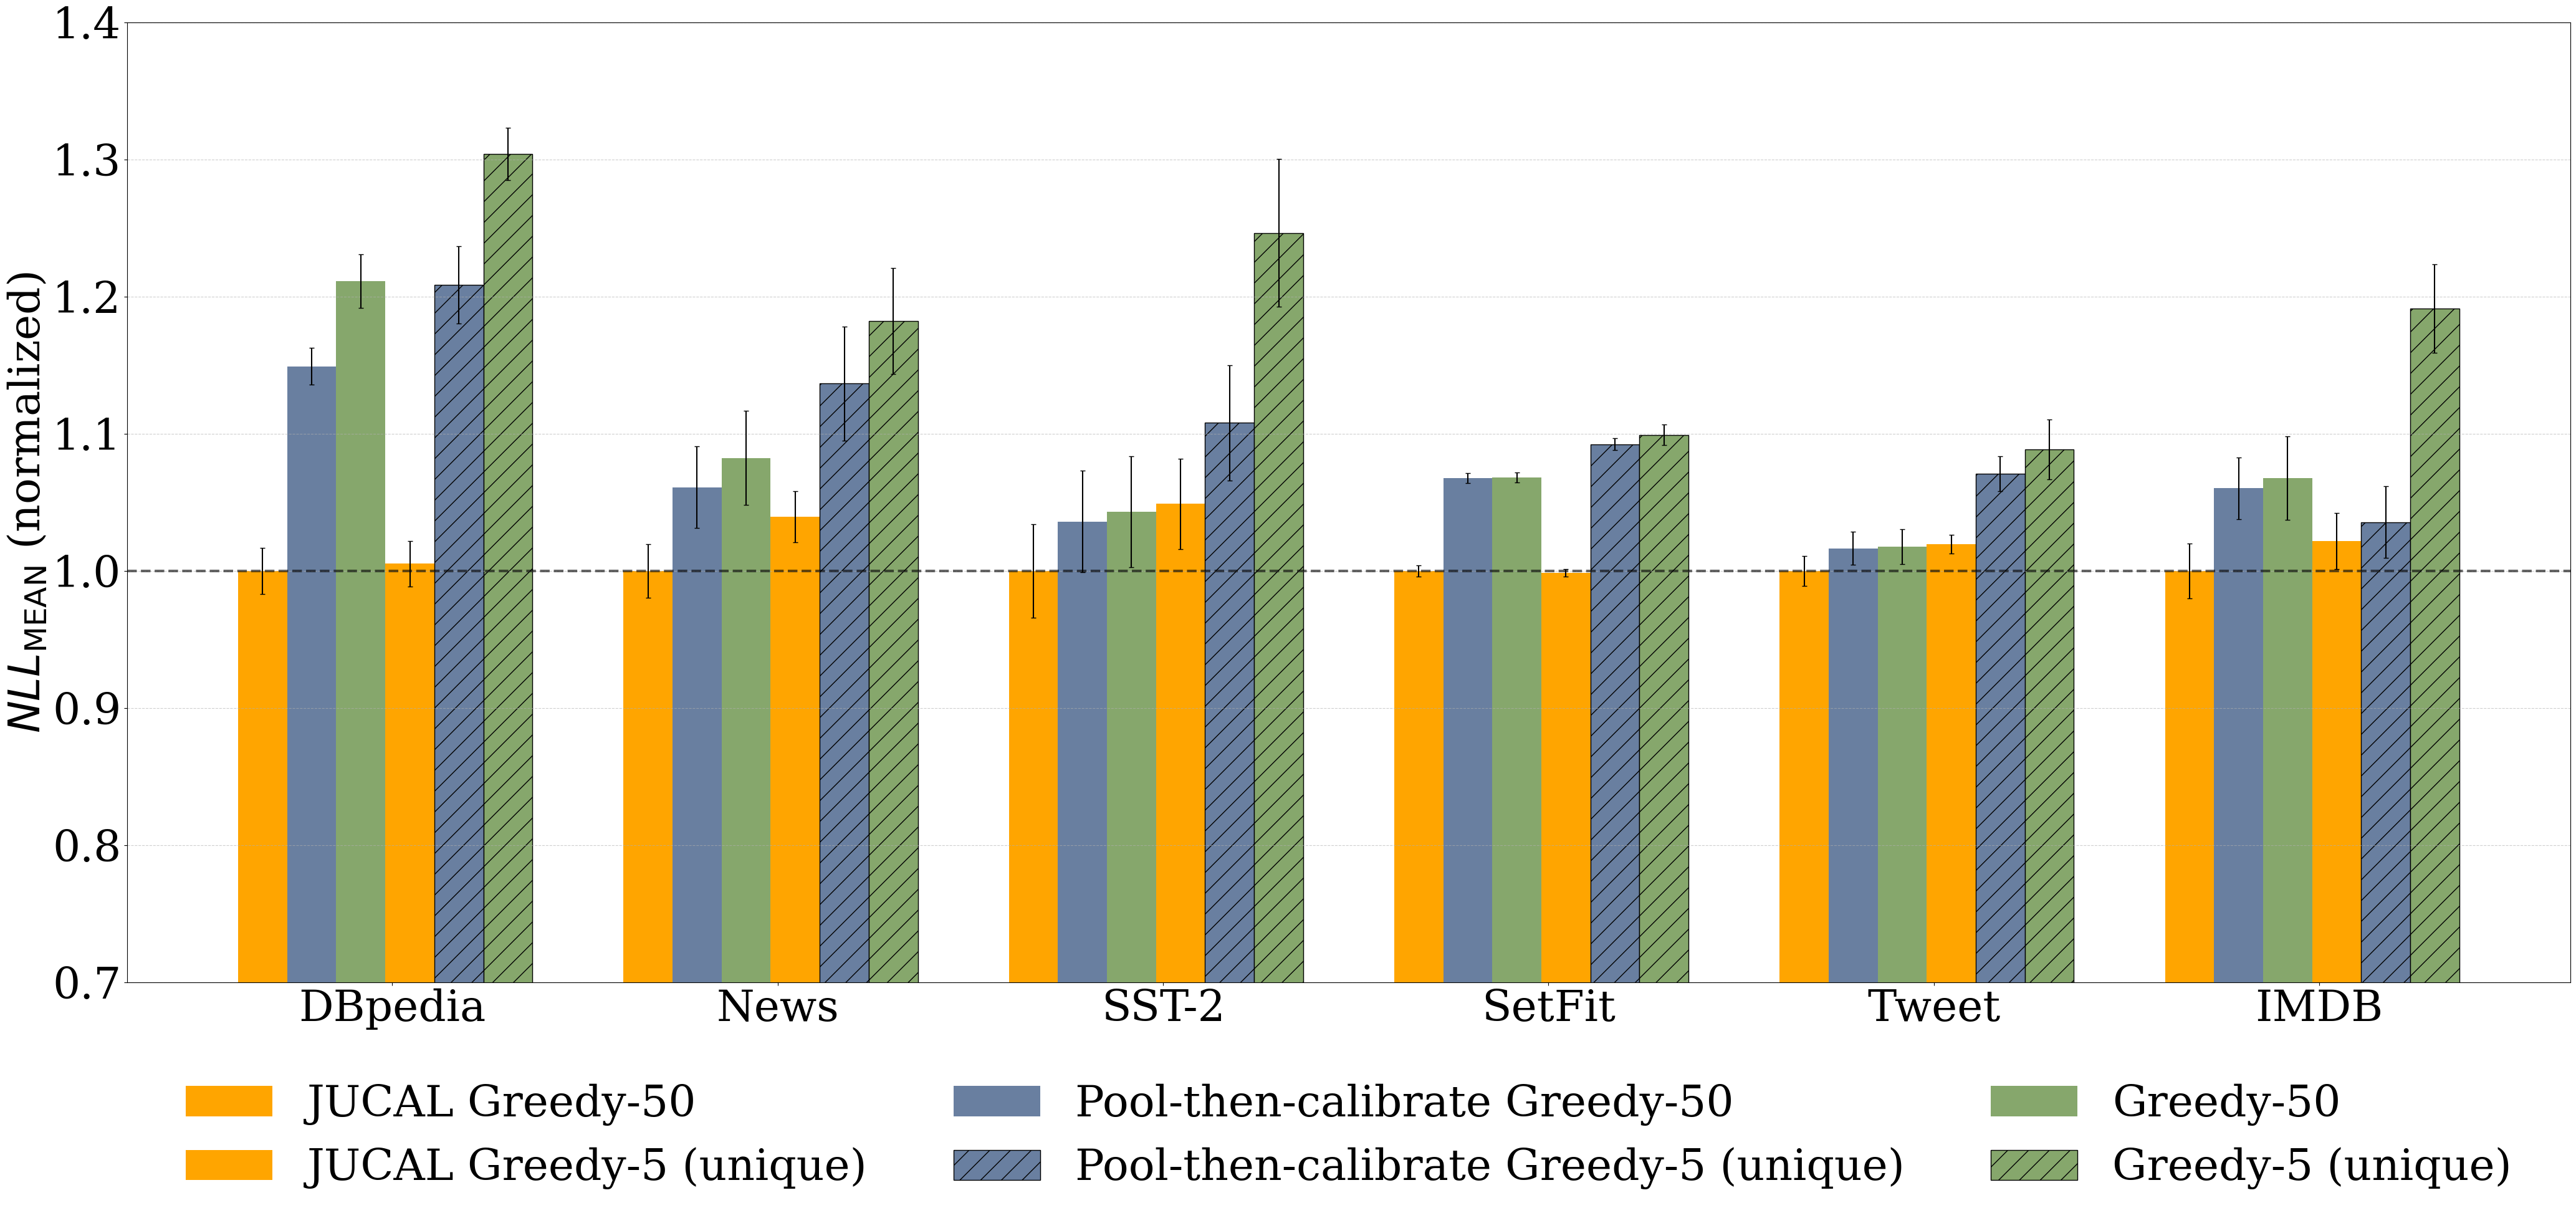

/var/folders/d8/h9n8d7kx4fl0x6kwm8bsfrrr0000gn/T/ipykernel_80641/3457615211.py:58: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


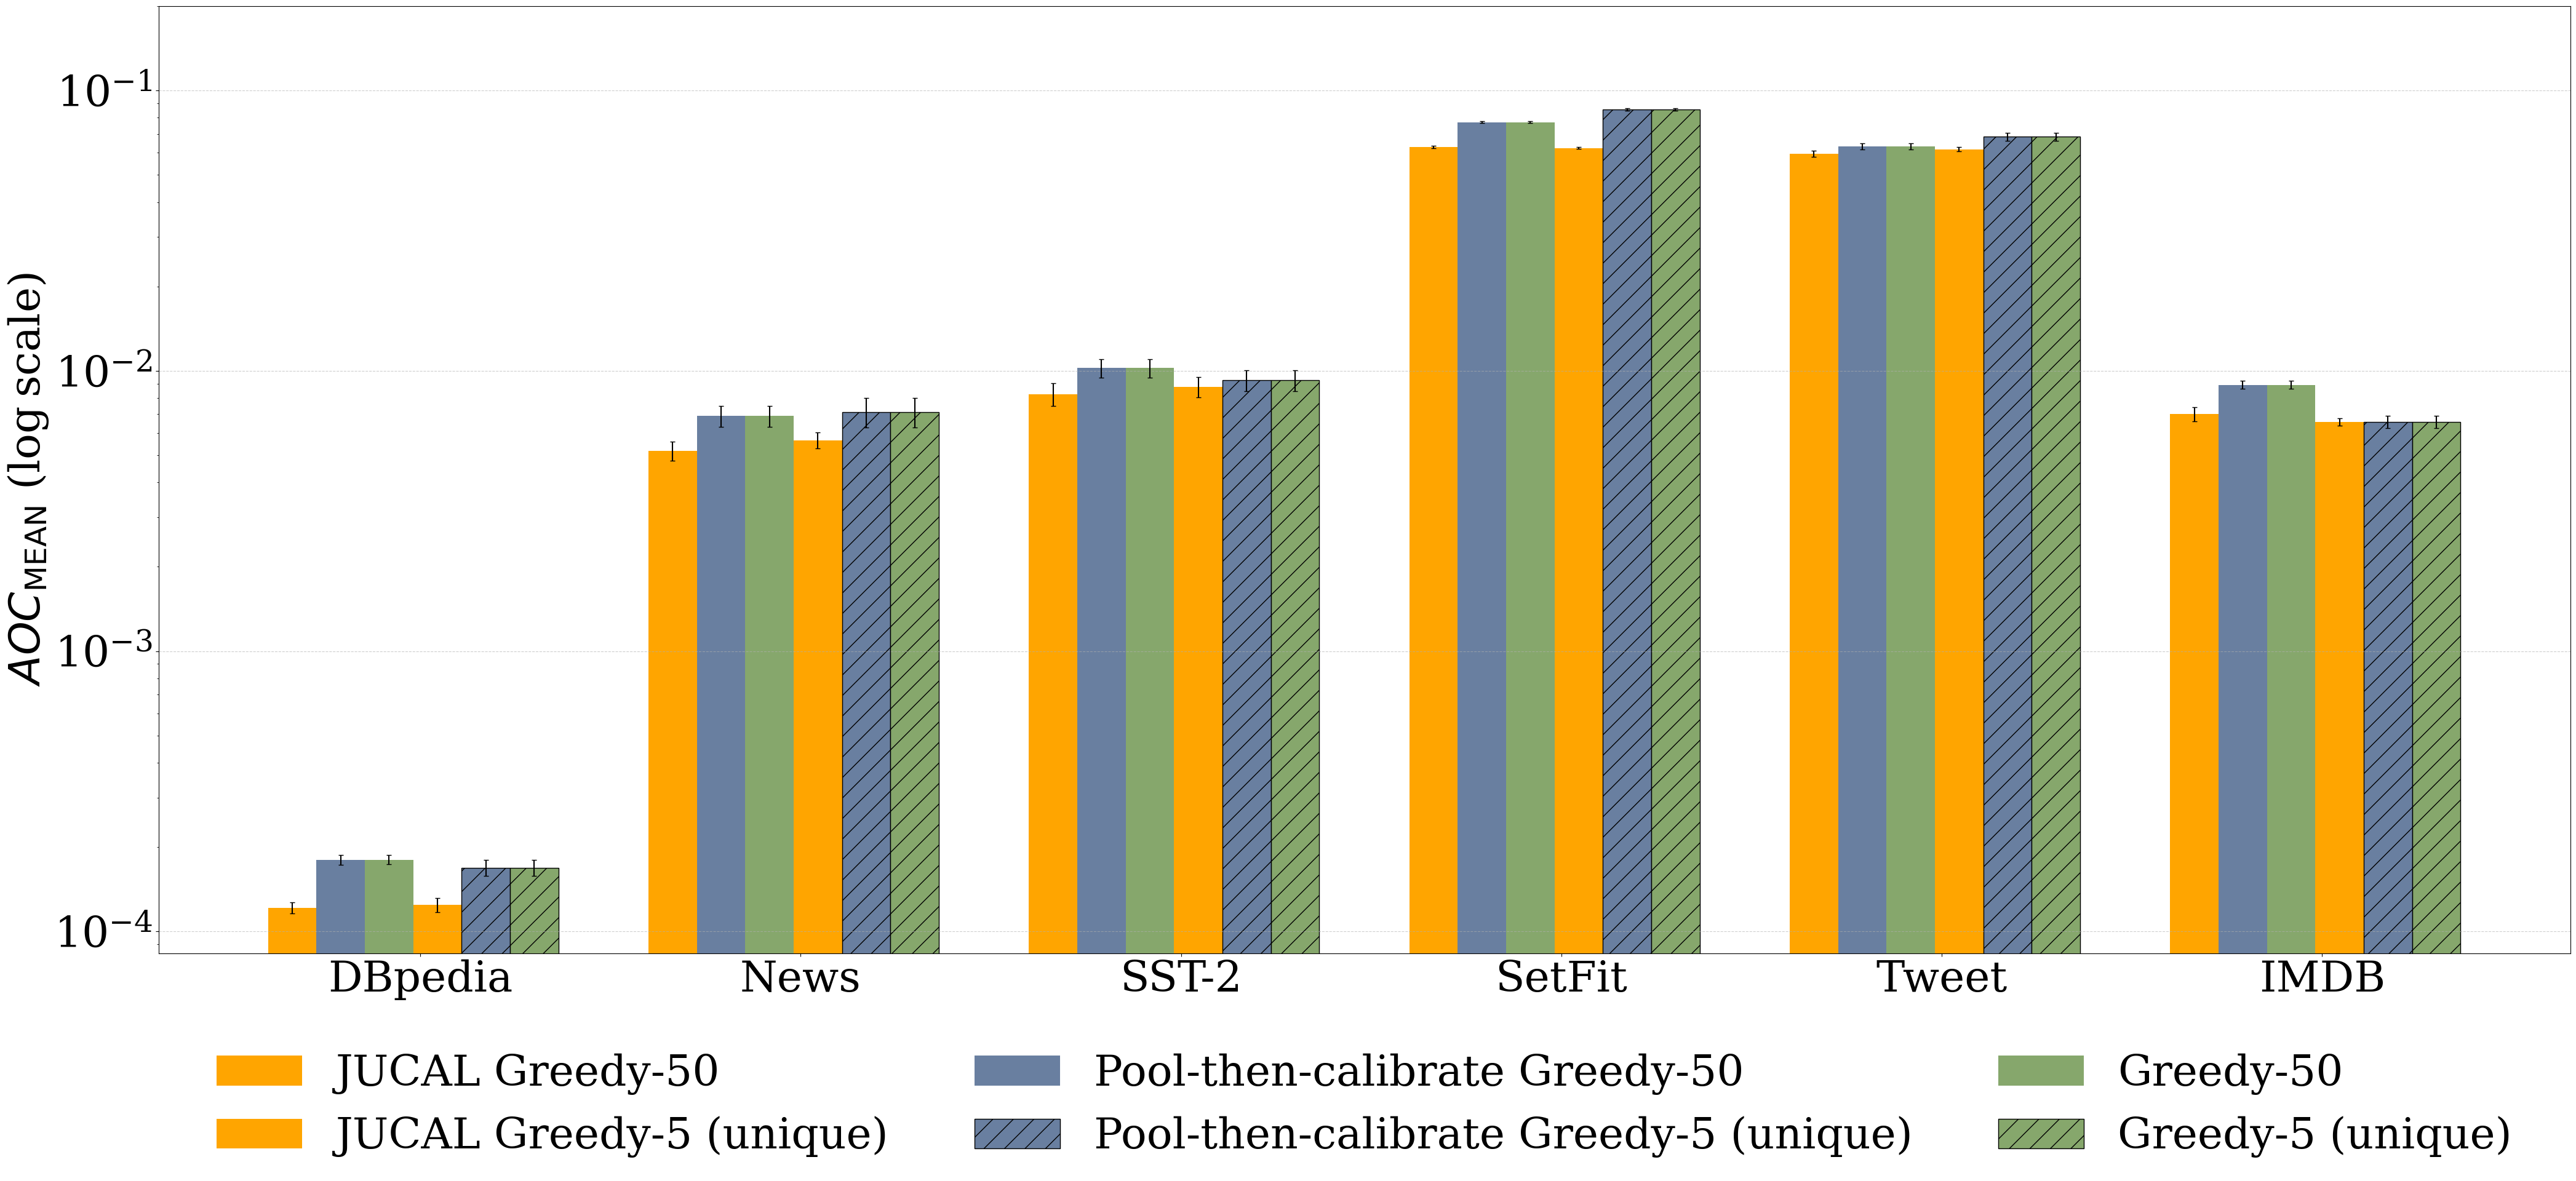

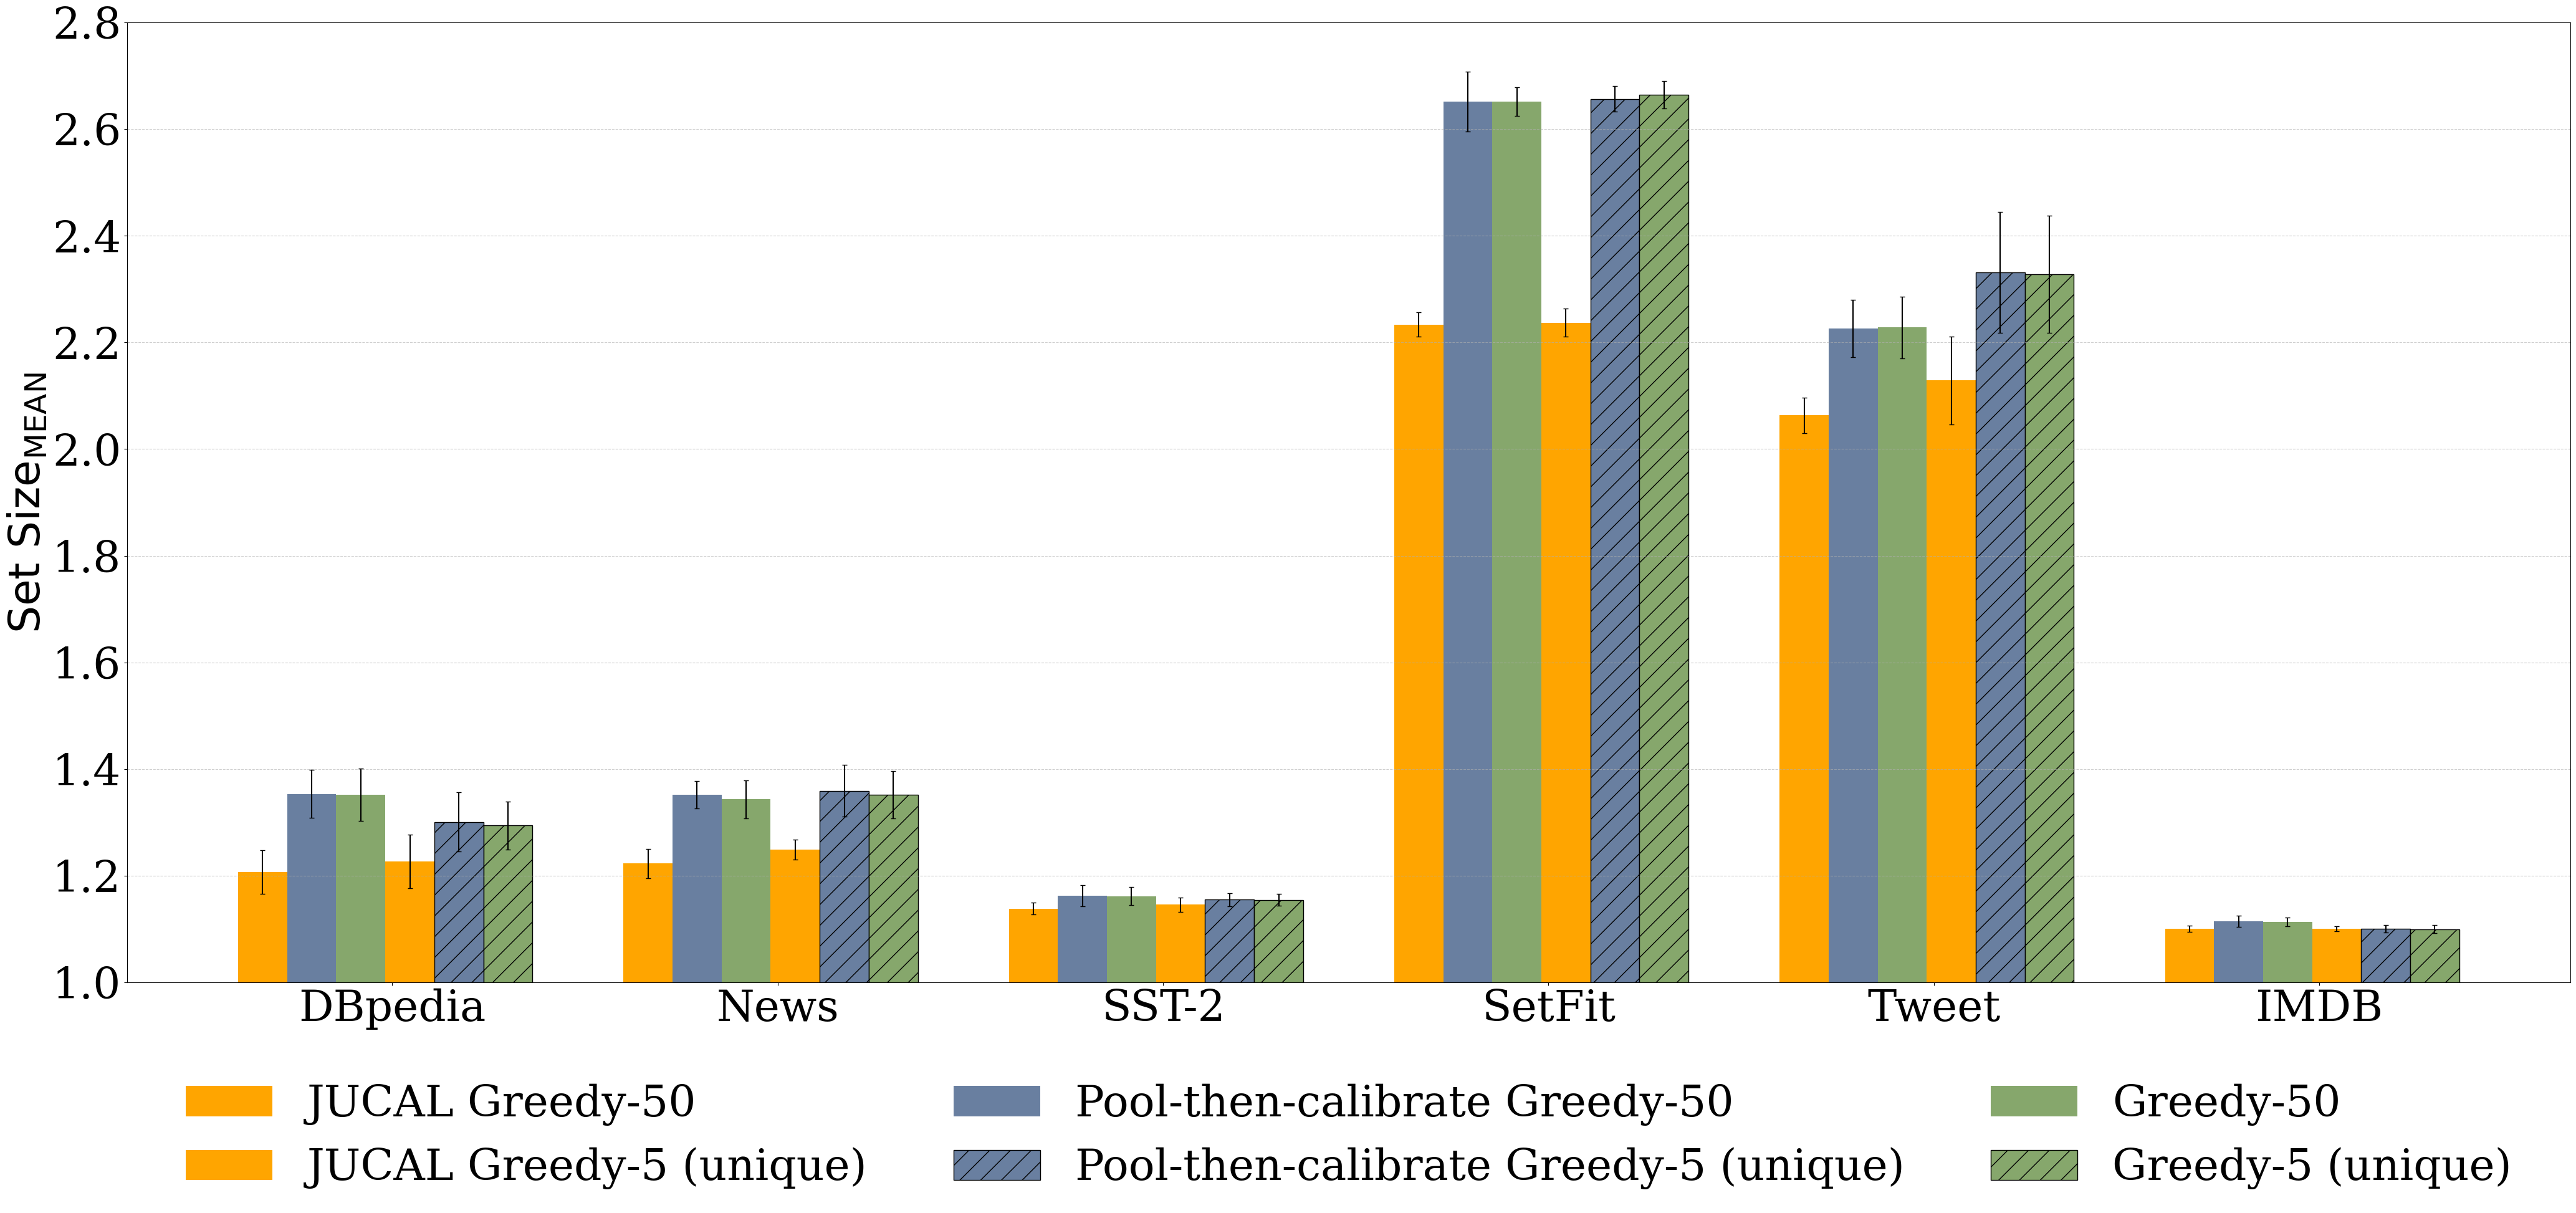

In [83]:
desired_order = ['DBpedia', 'News', 'SST-2', 'SetFit', 'Tweet', 'IMDB']
nll_ylim = (0.7, 1.4)
plot_metric(df_nll_stats, r'$NLL_{\mathrm{MEAN}}$ (normalized)', 'figures/ftc_nll_50&5.pdf', nll_ylim, False, desired_order) #'figures/ftc_nll.pdf'

#plot_metric(df_auc_stats, r'$AUC_{\mathrm{MEAN}}$', None, None, True, desired_order) #'figures/ftc_auc.pdf'
aoc_ylim = (0, 0.2) #NOTE this generates a warning
plot_metric(df_aoc_stats, r'$AOC_{\mathrm{MEAN}}$', 'figures/ftc_aoc_50&5.pdf', aoc_ylim, True, desired_order, False) #'figures/ftc_aoc.pdf'
set_ylim = (1, 2.8)
plot_metric(df_set_size_stats, r'$\text{Set Size}_{\mathrm{MEAN}}$', 'figures/ftc_set_size_50&5.pdf', set_ylim, 
            False, desired_order, dotted_line=False) # 'figures/ftc_set_size.pdf'

### RUN this for the 5 methods

This overrides previous names - dumb implementation but short on time

In [ ]:
ensemble_types = [
        'greedy_unique_5_baseline',
        'greedy_unique_5_temp_baseline',
        'greedy_unique_5_post_calib',
        'greedy_50_baseline',
        'greedy_50_temp_baseline'
    ]
df_ftc_nll = df_ftc_nll.loc[df_ftc_nll['ensemble_type'].isin(ensemble_types)]
df_ftc_auc = df_ftc_auc.loc[df_ftc_auc['ensemble_type'].isin(ensemble_types)]
df_ftc_set_size = df_ftc_set_size.loc[df_ftc_set_size['ensemble_type'].isin(ensemble_types)]

# rename the ensemble types
etype_map = {
    'greedy_unique_5_baseline':      'Greedy-5 (unique)',
    'greedy_unique_5_temp_baseline': 'Pool-then-calibrate Greedy-5 (unique)',
    'greedy_unique_5_post_calib':    'Jointly Calibrate Greedy-5 (unique)',
    'greedy_50_baseline':      'Greedy-50',
    'greedy_50_temp_baseline': 'Pool-then-calibrate Greedy-50'
}

for df in (df_ftc_nll, df_ftc_auc, df_ftc_set_size):
    df['ensemble_type'] = df['ensemble_type'].replace(etype_map)

df_ftc_nll.head(2)

In [ ]:
df_nll_stats      = compute_stats(df_ftc_nll,       'nll_test')
df_auc_stats      = compute_stats(df_ftc_auc,       'auc')
df_set_size_stats = compute_stats(df_ftc_set_size, 'set_size')

#normalize nll
#normalize_stats(df_nll_stats,  'greedy_50_post_calib')
#drop  'greedy_50_post_calib'
# drop that ensemble from both mean and std df_nll_stats, df_auc_stats, df_set_size_stats
#df_nll_stats      = df_nll_stats.     drop(
#    labels='greedy_50_post_calib', axis=1, level=1
#)

# === Original large‐figure style settings ===
plt.rcParams['text.usetex'] = False  # disable if no TeX installed
plt.rcParams.update({
    'font.family': 'serif',
})

# 1) derive labels from the pivot
#NOTE specify order here
ensemble_labels = [
    'Jointly Calibrate Greedy-5 (unique)',
    'Pool-then-calibrate Greedy-5 (unique)',
    'Greedy-5 (unique)',
    'Pool-then-calibrate Greedy-50',
    'Greedy-50',
]

# 2) define your gray palette
colors = {
    lbl: col for lbl, col in zip(
        ensemble_labels,
        #['#000000', '#555555', '#AAAAAA']
        ['#697fa0', 'orange', '#86a76c', '#88CCEE', 'Blue']
    )
}
#colors = {'PCS': 'orange', 'TopK (Random Forest)': '#697fa0', 'RAPS (Random Forest)': '#88CCEE', 'APS (Random Forest)': 'Blue', 'Majority Vote': '#86a76c'}


In [ ]:
# get the mean of SetFit dataset
df_nll_stats

In [ ]:
nll_ylim = (0.7, 1.4)
plot_metric(df_nll_stats, r'$NLL_{\mathrm{MEAN}}$ (normalized)', 'figures/ftc_nll_5_unique.pdf', nll_ylim, False, desired_order) #'figures/ftc_nll_5_unique.pdf'

### RUN just this for Mini

In [ ]:
ensemble_types = ['greedy_50_baseline', 'greedy_50_temp_baseline', 'greedy_50_post_calib']
#mini
df_mini_nll = df_mini_nll.loc[df_mini_nll['ensemble_type'].isin(ensemble_types)]

# rename the ensemble types
etype_map = {
    'greedy_50_baseline':      'Greedy-50',
    'greedy_50_temp_baseline': 'Pool-then-calibrate Greedy-50',
    'greedy_50_post_calib':    'Jointly Calibrate Greedy-50'
}
#mini
df_mini_nll['ensemble_type'] = df_mini_nll['ensemble_type'].replace(etype_map)
df_mini_nll.head(2)

In [ ]:
df_nll_stats      = compute_stats(df_mini_nll,       'nll_test')

#normalize nll
normalize_stats(df_nll_stats,  'Jointly Calibrate Greedy-50')

# === Original large‐figure style settings ===
plt.rcParams['text.usetex'] = False  # disable if no TeX installed
plt.rcParams.update({
    'font.family': 'serif',
})

# 1) derive labels from the pivot
#NOTE specify order here
ensemble_labels = [
    'Jointly Calibrate Greedy-50',
    'Pool-then-calibrate Greedy-50',
    'Greedy-50'
]

# 2) define your gray palette
colors = {
    lbl: col for lbl, col in zip(
        ensemble_labels,
        #['#000000', '#555555', '#AAAAAA']
        ['#697fa0', 'orange', '#86a76c']
    )
}

In [ ]:
desired_order = ['DBpedia-mini', 'News-mini', 'SST-2-mini', 'SetFit-mini', 'Tweet-mini', 'IMDB-mini']
nll_ylim = (0.7, 1.3)
plot_metric(df_nll_stats, r'$NLL_{\mathrm{MEAN}}$ (normalized)', 'figures/mini_nll.pdf', nll_ylim, False, desired_order) #'figures/mini_nll.pdf'

### Old plotting fn

In [ ]:
def plot_metric(
    df_stats,
    ylabel,
    filename=None,
    ylim=None,
    logscale=False,
    order: list[str] = None,  #order of datasets,
    dotted_line: bool = True
):
    n_methods = len(ensemble_labels)

    # pull out mean/std tables
    df_plot     = df_stats['mean_val'][ensemble_labels].copy()
    df_plot_std = df_stats['std_val'] [ensemble_labels].copy()

    # — reorder rows if order given, else sort by the first method’s mean —
    if order is not None:
        # Only keep and arrange the rows in order; any missing will become NaN
        df_plot     = df_plot.reindex(order)
        df_plot_std = df_plot_std.reindex(order)
    else:
        df_plot     = df_plot.sort_values(by=ensemble_labels[0], ascending=True)
        df_plot_std = df_plot_std.reindex(df_plot.index)
    # — end reorder logic —

    means = np.vstack([df_plot    [lbl].values for lbl in ensemble_labels])
    stds  = np.vstack([df_plot_std[lbl].values for lbl in ensemble_labels])

    x     = np.arange(len(df_plot)) * 4.0
    width = 0.7

    fig, ax = plt.subplots(figsize=(30,20), dpi=100)
    for i, lbl in enumerate(ensemble_labels):
        ax.bar(
            x + i*width - (n_methods-1)*width/2,
            means[i],
            width,
            yerr=stds[i],
            capsize=3,
            alpha=1.0,
            color=colors[lbl],
            label=lbl
        )

    # logscale
    if logscale:
        ax.set_yscale('log')
        ylabel = ylabel + ' (log scale)'    # annotate the label
    if dotted_line:
        ax.axhline(1, linestyle='--', color='black', alpha=0.6, linewidth=3)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_ylabel(ylabel, fontsize=50)
    ax.set_xticks(x + 0.1)
    ax.set_xticklabels(df_plot.index.tolist(), rotation=0, ha='center', fontsize=50)
    ax.tick_params(axis='y', labelsize=50)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)


    # —— split‐legend block borrowed from your colleague’s code —— 
    handles, labels = ax.get_legend_handles_labels()
    ncols  = 2
    nlines = len(handles)
    kw = dict(
        framealpha=1, 
        borderaxespad=0, 
        bbox_to_anchor=(0.5, -0.2),    #where to put the legend
        edgecolor="w", 
        fontsize=50
    )
    # bottom row: first ncols entries
    leg1 = ax.legend(
        handles=handles[: nlines//ncols * ncols],
        labels=labels[: nlines//ncols * ncols],
        ncol=ncols,
        loc="lower center",
        **kw
    )
    ax.add_artist(leg1)
    # top row: remaining entries
    leg2 = ax.legend(
        handles=handles[nlines//ncols * ncols :],
        labels=labels[nlines//ncols * ncols :],
        ncol=nlines - nlines//ncols * ncols,
        loc="upper center",
        **kw
    )
    # — end split‐legend block ——

    # make room for bottom legend
    plt.subplots_adjust(bottom=0.25)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=2000, bbox_inches='tight')
    plt.show()

# Epistemic uncertainty analysis

#### Calc the variation in ensemble probs

Index(['dataset', 'seed', 'method', 'ensemble_type', 'ensemble_size',
       'ensemble_unique_size', 'nll_test', 'c1', 'c2', 'epi_scalar', 'path',
       'metadata_version', 'MC Aleatoric Mean', 'MC Epistemic Mean',
       'MC Total Mean', 'P Aleatoric Mean', 'P Epistemic Mean',
       'P Total Mean'],
      dtype='object')
['Epistemic Uncertainty (Extended)', 'Epistemic Uncertainty (Mini)', 'Aleatoric Uncertainty (Extended)', 'Aleatoric Uncertainty (Mini)']


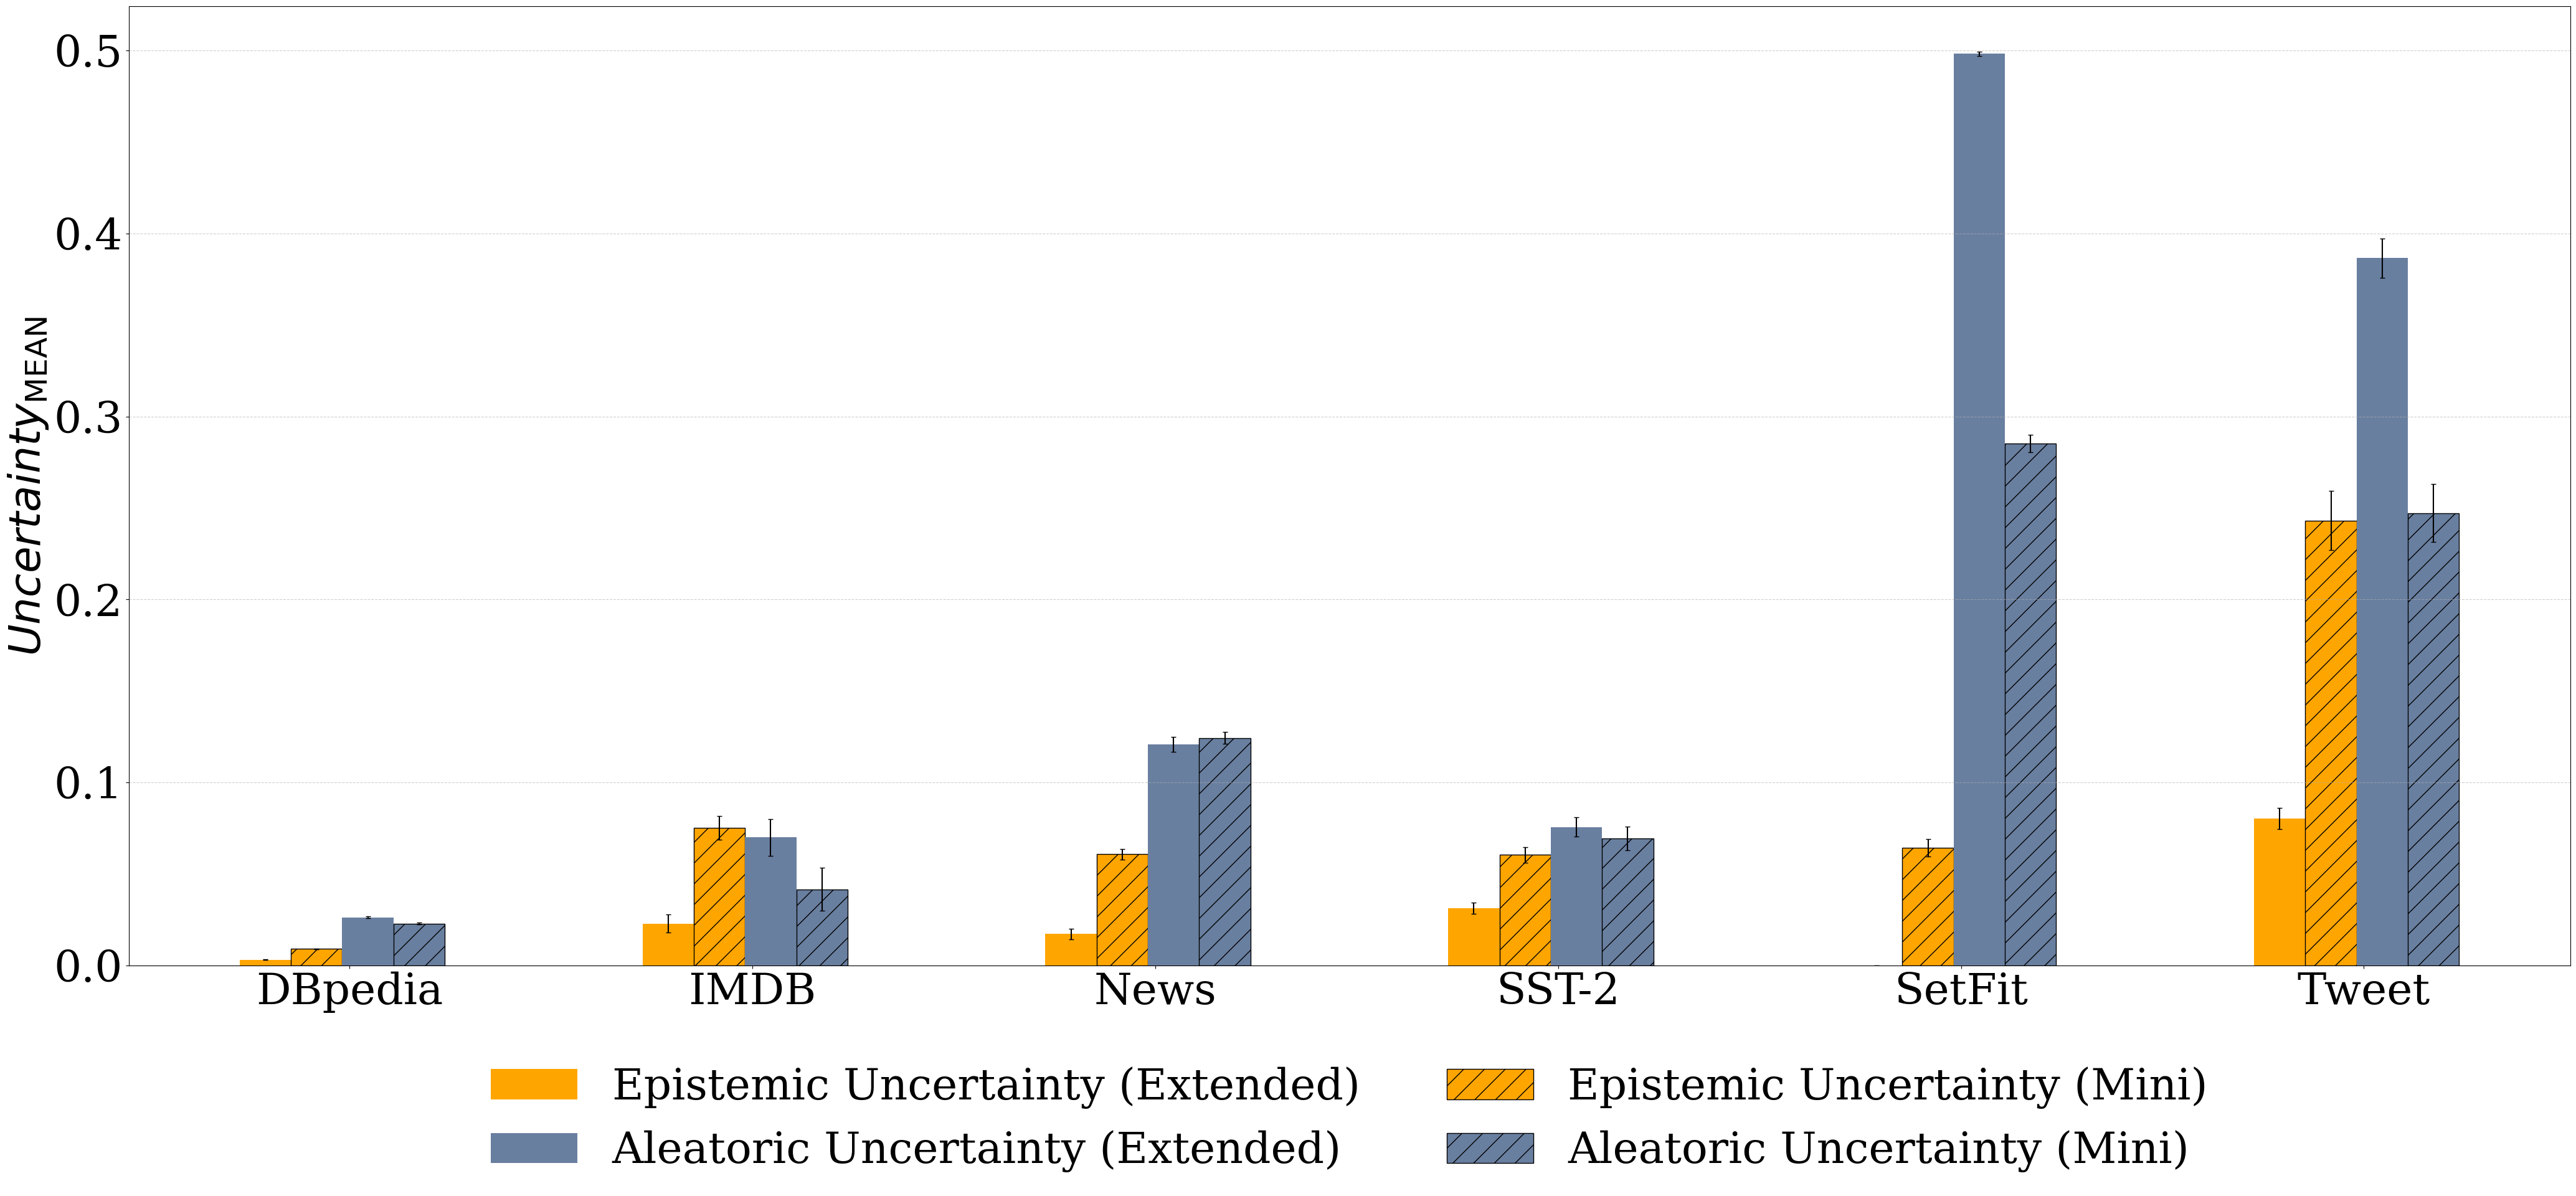

In [87]:
df_uncertainty = pd.read_csv('Ensembling_Finetuned_LLMs/llm_experiments_data/calibrated_uncertainties.csv')
print(df_uncertainty.columns)
method = 'pure_logits'
df_uncertainty = df_uncertainty.loc[(df_uncertainty['method'] == method)]
# rename the dataset and the ensemble types
dataset_map = {
    'SetFit/mnli': 'SetFit',
    'ag_news':     'News',
    'dbpedia_14':  'DBpedia',
    'imdb':        'IMDB',
    'mteb/tweet_sentiment_extraction': 'Tweet',
    'stanfordnlp/sst2':              'SST-2'
}
df_uncertainty['dataset'] = df_uncertainty['dataset'].replace(dataset_map)
# rename the ensemble types
etype_map = {
    'greedy_50_post_calib':    'JUCAL Greedy-50'
}
df_uncertainty['ensemble_type'] = df_uncertainty['ensemble_type'].replace(etype_map)
df_uncertainty

#calc mean and std of the uncertainty across the seeds
df_uncertainty_stats = (
    df_uncertainty.groupby(['dataset','ensemble_type', 'method', 'metadata_version'])[['MC Aleatoric Mean', 'MC Epistemic Mean',
       'MC Total Mean', 'P Aleatoric Mean', 'P Epistemic Mean',
       'P Total Mean']].agg(['mean','std']).rename(columns={'mean':'mean_val','std':'std_val'})
)

df_uncertainty_stats = df_uncertainty_stats.unstack(level=1) # moving 'method' to columns -was amongmulti index rows


metrics = ['MC Epistemic Mean', 'MC Aleatoric Mean']
metrics = ['P Epistemic Mean', 'P Aleatoric Mean']

col_name_map = {
    'MC Epistemic Mean_extended': 'Epistemic Uncertainty (Extended)',
    'MC Epistemic Mean_mini': 'Epistemic Uncertainty (Mini)',
    'MC Aleatoric Mean_extended': 'Aleatoric Uncertainty (Extended)',
    'MC Aleatoric Mean_mini': 'Aleatoric Uncertainty (Mini)'
}

col_name_map = {
   'P Epistemic Mean_extended': 'Epistemic Uncertainty (Extended)',
    'P Epistemic Mean_mini': 'Epistemic Uncertainty (Mini)',
    'P Aleatoric Mean_extended': 'Aleatoric Uncertainty (Extended)',
    'P Aleatoric Mean_mini': 'Aleatoric Uncertainty (Mini)'
}

#-------- mean and std pivot ----------
# mean pivot
df_mean = df_uncertainty_stats.xs('mean_val', axis=1, level=1).reset_index().loc[:, ['dataset', 'metadata_version'] + metrics]
mean_pivot = df_mean.pivot(index='dataset', columns='metadata_version')[metrics]
mean_pivot.columns = mean_pivot.columns.droplevel(1)   #drop level 1 in columns
#join column label names across the two levels
mean_pivot.columns = [f'{col[0]}_{col[1]}' for col in mean_pivot.columns]
#rename the columns
mean_pivot = mean_pivot.rename(columns=col_name_map)

#std pivot
df_std = df_uncertainty_stats.xs('std_val', axis=1, level=1).reset_index().loc[:, ['dataset', 'metadata_version'] + metrics]
std_pivot = df_std.pivot(index='dataset', columns='metadata_version')[metrics]
std_pivot.columns = std_pivot.columns.droplevel(1)   #drop level 1 in columns
#join column label names across the two levels
std_pivot.columns = [f'{col[0]}_{col[1]}' for col in std_pivot.columns]
#rename the columns
std_pivot = std_pivot.rename(columns=col_name_map)

# === style & colors ===
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.family':'serif'})

colors = {
    'Epistemic Uncertainty (Extended)': 'orange',
    'Epistemic Uncertainty (Mini)':     'orange',
    'Aleatoric Uncertainty (Extended)': '#697fa0',
    'Aleatoric Uncertainty (Mini)':     '#697fa0',
}

# which bars to hatch?
striped_labels = ['Epistemic Uncertainty (Mini)', 'Aleatoric Uncertainty (Mini)']

# === plotting ===
datasets = mean_pivot.index.tolist()
labels   = mean_pivot.columns.tolist()
print(labels)
means    = mean_pivot.values
stds     = std_pivot.values

n_datasets, n_bars = means.shape
x     = np.arange(n_datasets) * 5.5   # same spacing as your old code
width = 0.7

fig, ax = plt.subplots(figsize=(40,20), dpi=100)
for i, lbl in enumerate(labels):
    hatch = '/' if lbl in striped_labels else None
    ax.bar(
        x + i*width - (n_bars-1)*width/2,
        means[:, i],
        width,
        yerr=stds[:, i],
        capsize=3,
        alpha=1.0,
        color=colors[lbl],
        hatch=hatch,
        edgecolor='black' if hatch else None,
        label=lbl
    )

# optional: remove or keep
#ax.axhline(1, linestyle='--', color='black', alpha=0.6, linewidth=3)

# logscale

ylabel = '$Uncertainty_{\mathrm{MEAN}}$'   # annotate the label
#ax.set_yscale('log')
#ylabel = ylabel + ' (log scale)'    # annotate the label

ax.set_ylabel(ylabel, fontsize=50)
ax.set_xticks(x + 0.1)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=50)
ax.tick_params(axis='y', labelsize=50)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)



# ---- legend underneath in row-major order ----
handles, labls = ax.get_legend_handles_labels()
ncol = 2
n    = len(handles)
nrows= math.ceil(n/ncol)
new_order = [
    r*ncol + c
    for c in range(ncol)
    for r in range(nrows)
    if r*ncol + c < n
]
handles = [handles[i] for i in new_order]
labls   = [labls  [i] for i in new_order]

leg = fig.legend(
    handles, labls,
    ncol=ncol,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    framealpha=0.0,
    borderaxespad=0,
    fontsize=50
)

plt.subplots_adjust(
    left=0.01,
    right=0.99,
    top=0.95,
    bottom=0.18
)

#path for saving
plt.savefig('figures/uncertainty_JUCAL.pdf', dpi=2000, bbox_inches='tight')

plt.show()